# Spectral Density Computations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

## Part 1: Define the activation function

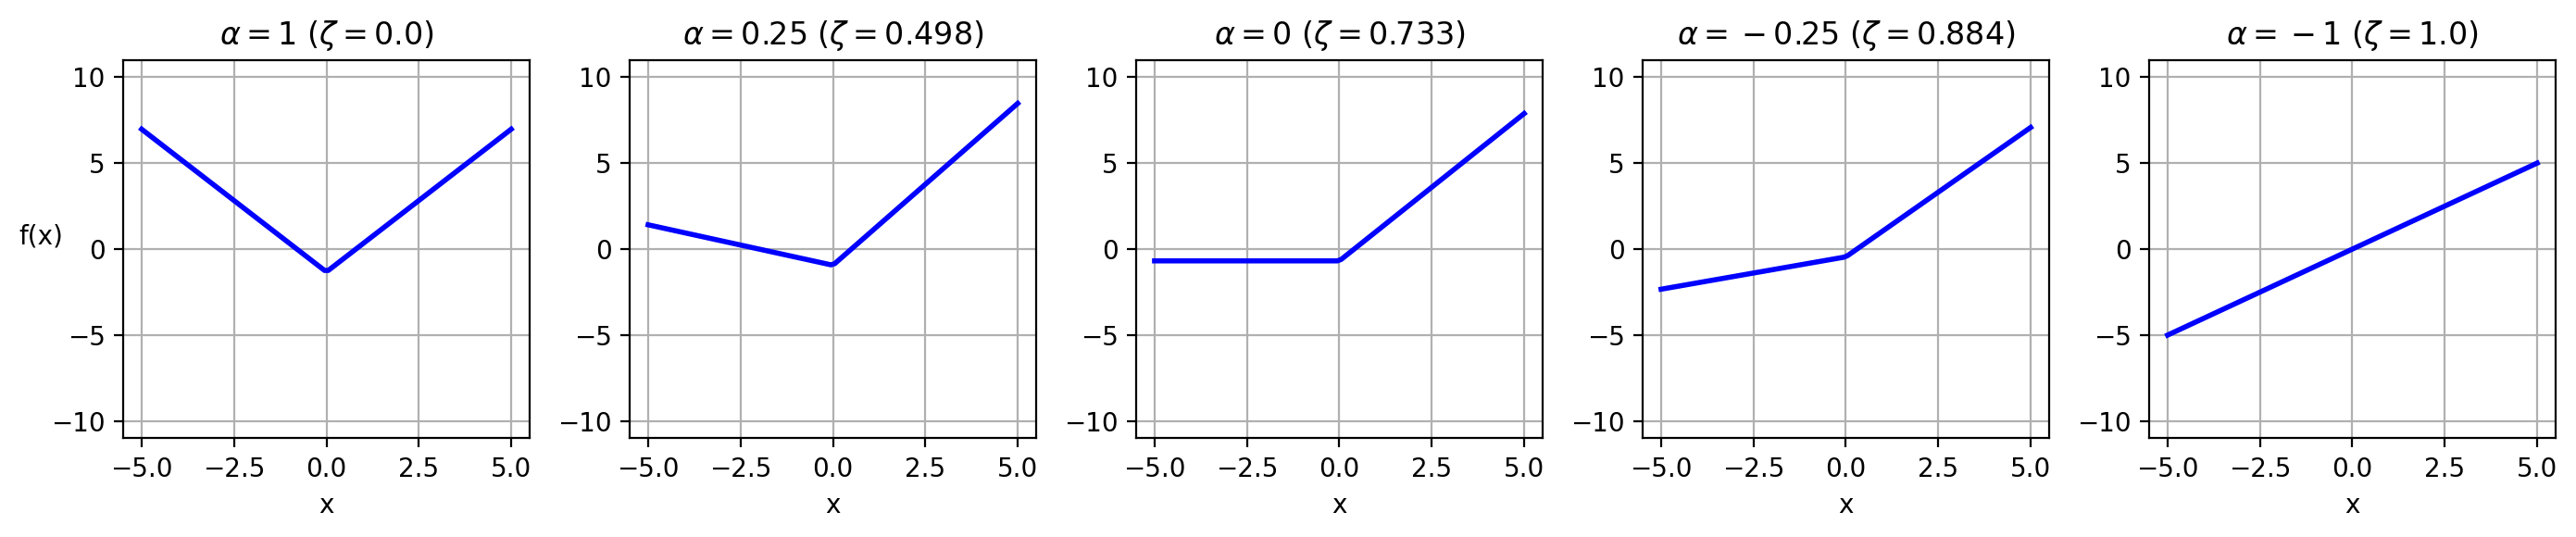

In [2]:
def relu(x):
    return np.maximum(x, 0)

def relu_modified(x, alpha):
    scale = np.sqrt(0.5 * (1 + alpha ** 2) - 0.5 * (1 / np.pi) * (1 + alpha) ** 2)
    return (relu(x) + alpha * relu(-x) - (1 + alpha) / np.sqrt(2 * np.pi)) / scale

def compute_zeta(alpha):
    return (1 - alpha) ** 2 / (2 * (1 + alpha ** 2) - (2 / np.pi) * (1 + alpha) ** 2)

plt.figure(figsize=(14, 3), dpi=200)
x = np.linspace(-5, 5, 100)

for i, alpha in enumerate([1, 0.25, 0, -0.25, -1]):

    plt.subplot(1, 5, i + 1)
    title = "$\\alpha = {}$ $(\\zeta = {})$"
    plt.title(title.format(alpha, np.round(compute_zeta(alpha), decimals=3)))
    plt.plot(x, relu_modified(x, alpha), lw=2, c="b")
    plt.ylim([-11, 11])
    plt.xlabel("x")
    plt.grid()

    if i == 0:
        plt.ylabel("f(x)", rotation=0)

plt.tight_layout()
plt.show()

## Part 2: Build data matrices

In [3]:
def build_X(n0, m, sigma_x, seed=None):
    rng = np.random.default_rng(seed=seed)
    return sigma_x * rng.standard_normal(size=(n0, m))

def build_W(n0, n1, sigma_w, seed=None):
    rng = np.random.default_rng(seed=seed)
    return (sigma_w / np.sqrt(n0)) * rng.standard_normal(size=(n1, n0))

# Choose data dimension parameters:
n0 = 10  # data matrix size
phi = 1  # size ratio for X
psi = 1  # size ratio for W

m = int(n0 / phi)
n1 = int(n0 / psi)

# Choose standard deviations:
sigma_x = 1
sigma_w = 1

# Choose an activation function:
f = lambda x: relu_modified(x, alpha=1)

# Build matrices:
X = build_X(n0, m, sigma_x)
W = build_W(n0, n1, sigma_w)
Y = f(W.dot(X))
M = (1 / m) * Y.dot(Y.T)

## Part 3: Compute the empirical density

100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


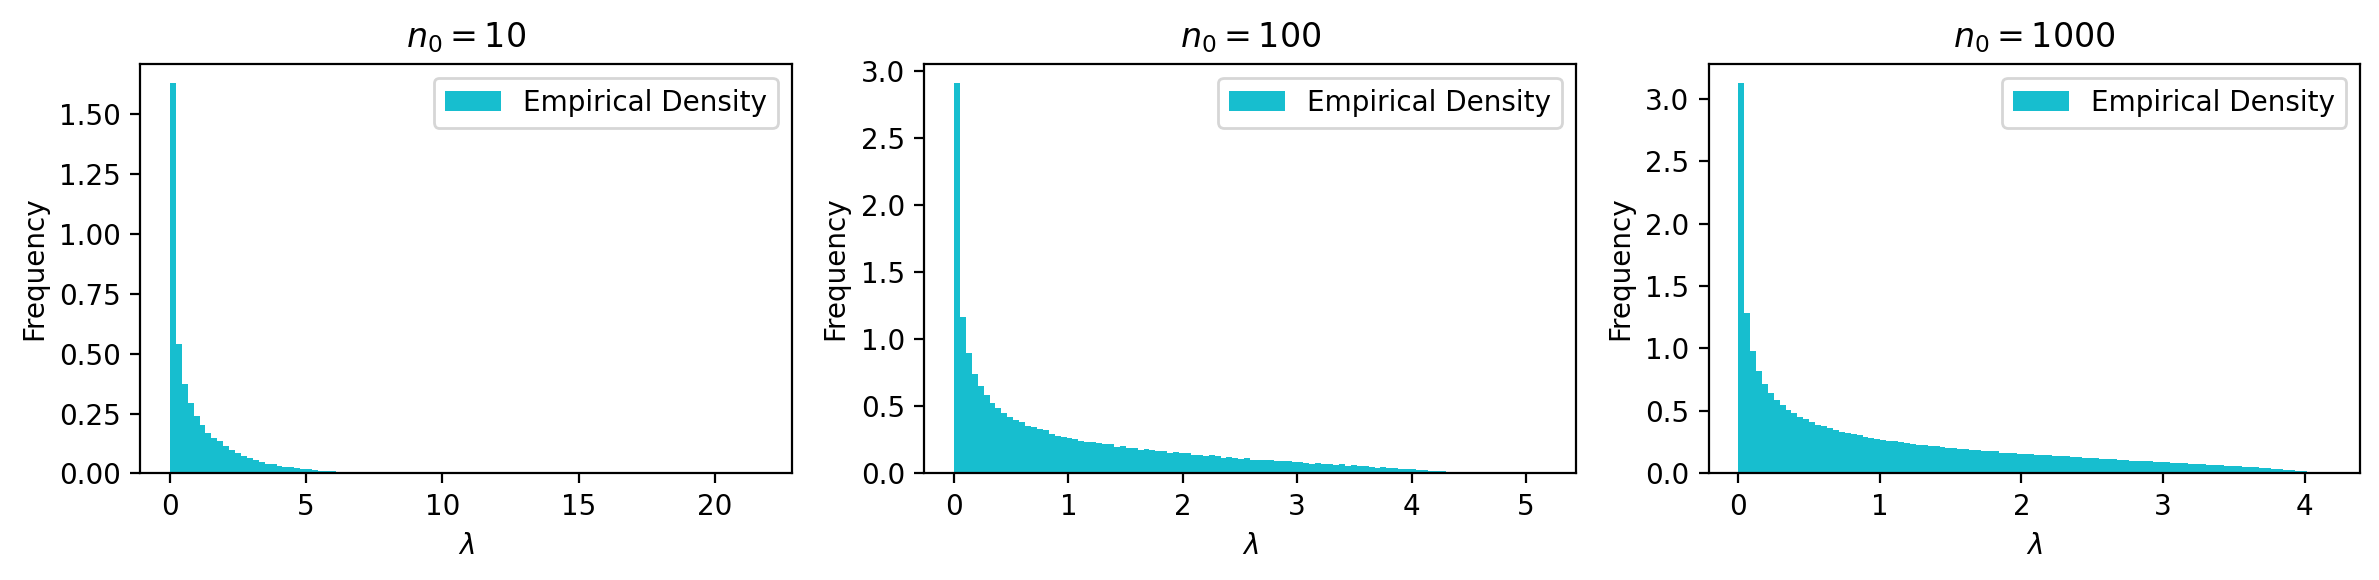

In [4]:
def build_gram(n0, f, phi=1, psi=1, sigma_x=1, sigma_w=1):
    m = int(n0 / phi)
    n1 = int(n0 / psi)
    X = build_X(n0, m, sigma_x)
    W = build_W(n0, n1, sigma_w)
    Y = f(W.dot(X))
    M = (1 / m) * Y.dot(Y.T)
    return M

all_eigs = []
n0_vals = np.logspace(1, 3, 3).astype(int)

f = lambda x: relu_modified(x, alpha=1)

for i, n0 in enumerate(n0_vals):
    all_eigs_i = []
    num_trials = int(1e+5 / n0)
    for _ in tqdm(range(num_trials)):
        M = build_gram(n0, f)
        all_eigs_i.append(np.linalg.eigh(M)[0]) # Gram matrix is symmetric

    all_eigs.append(all_eigs_i)

# Plot the empirical densities.
plt.figure(figsize=(12, 3), dpi=200)
for i, (n0, eigs) in enumerate(zip(n0_vals, all_eigs)):
    plt.subplot(1, len(n0_vals), i + 1)
    plt.hist(
        np.array(eigs).flatten(),
        density=True,
        bins=100,
        color="tab:cyan",
        label="Empirical Density",
    )
    plt.title(f"$n_0 = {n0}$")
    plt.xlabel("$\\lambda$")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

## Part 4: Compute the theoretical density $(\zeta = 0)$
Choose $\phi = \psi = 1$ for simplicity.

$$
\eta z\big[G(z)\big]^2 - z\big[G(z)\big] + 1 = 0
$$

$$
G(z) = \frac{z \pm \sqrt{z^2 - 4 z}}{2 z}, \quad \eta = 1
$$

alpha = 1 (zeta = 0)


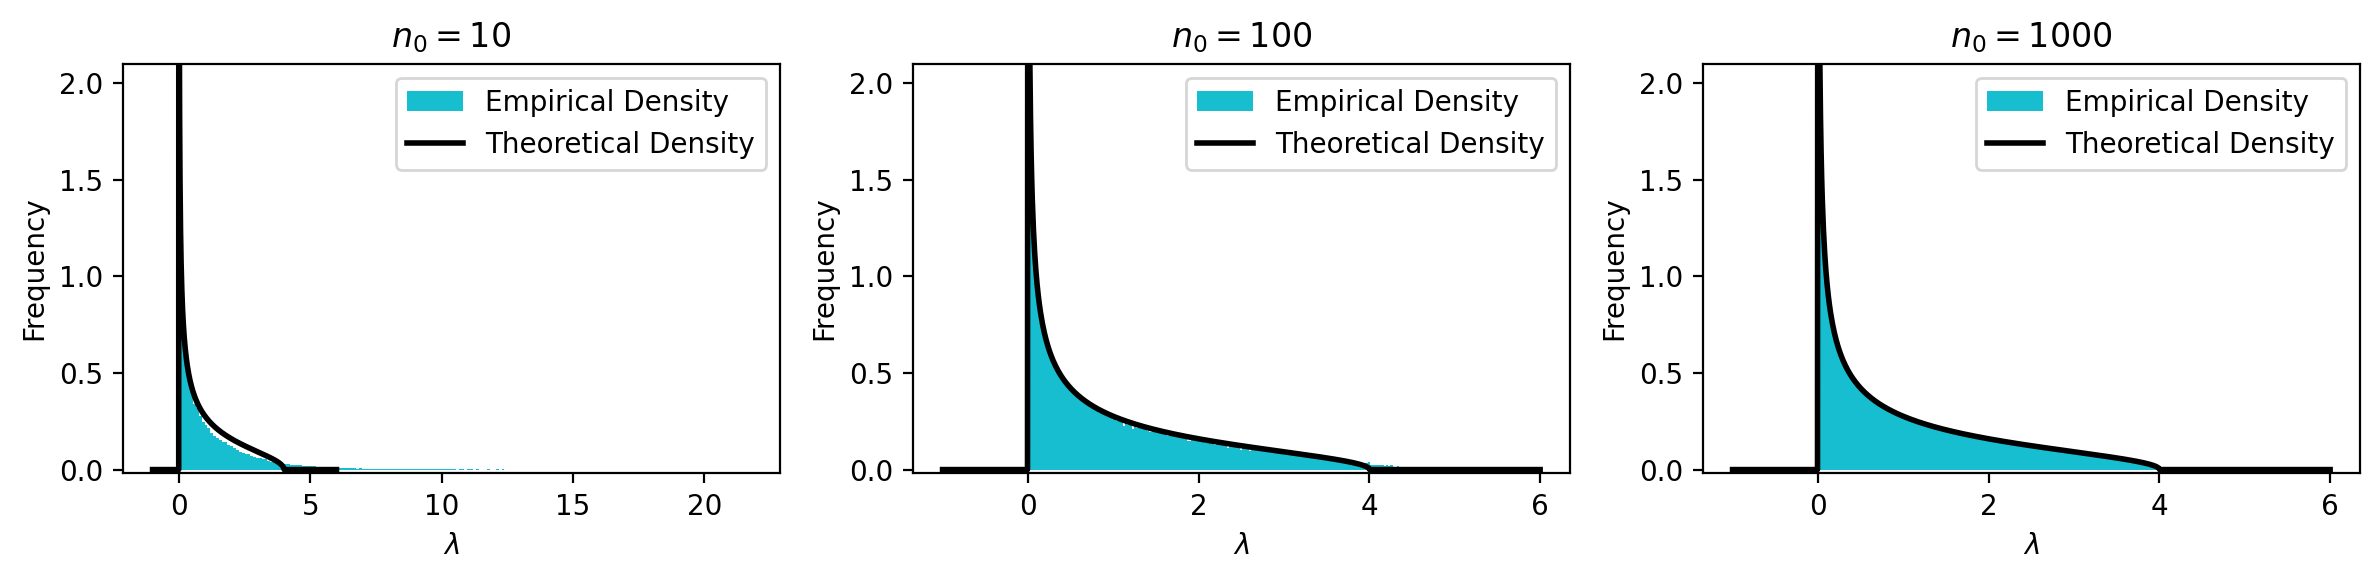

In [5]:
def G_0(z):
    """
    True theoretical G(z) for the zeta = 0 case.
    """
    G_pos = (z + np.sqrt(z ** 2 - 4 * z)) / (2 * z)
    G_neg = (z - np.sqrt(z ** 2 - 4 * z)) / (2 * z)

    return np.where(G_pos.imag < G_neg.imag, G_pos, G_neg)

# Compute G(z) for z (nearly) real on [-1, 6].
z = np.linspace(-1, 6, 1000).astype("complex") + (1j * 1e-16)
true_density = -(1 / np.pi) * G_0(z).imag

# Plot the empirical densities vs. theoretical.
print("alpha = 1 (zeta = 0)")
plt.figure(figsize=(12, 3), dpi=200)
for i, (n0, eigs) in enumerate(zip(n0_vals, all_eigs)):
    plt.subplot(1, len(n0_vals), i + 1)

    # (1) Empirical.
    plt.hist(
        np.array(eigs).flatten(),
        density=True,
        bins=200,
        color="tab:cyan",
        label="Empirical Density"
    )

    # (2) Theoretical.
    plt.plot(z.real, true_density, lw=2, c="k", label="Theoretical Density")

    plt.ylim([-0.02, 2.1])
    plt.title(f"$n_0 = {n0}$")
    plt.xlabel("$\\lambda$")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

## Part 5: Compute the theoretical density $(\zeta \neq 0)$
Choose $\phi = \psi = 1$ for simplicity.

$$
z^2(\zeta^2-\eta \zeta) \big[G(z)\big]^4 + z^2 \zeta \big[G(z)\big]^3 + z(\eta - \zeta)\big[G(z)\big]^2 - z\big[G(z)\big] + 1 = 0
$$

$$
h(G) := z^2(\zeta^2-\eta \zeta) G^4 + z^2 \zeta G^3 + z(\eta - \zeta)G^2 - zG + 1 = 0
$$

Initial Conditions for Newton's Method:


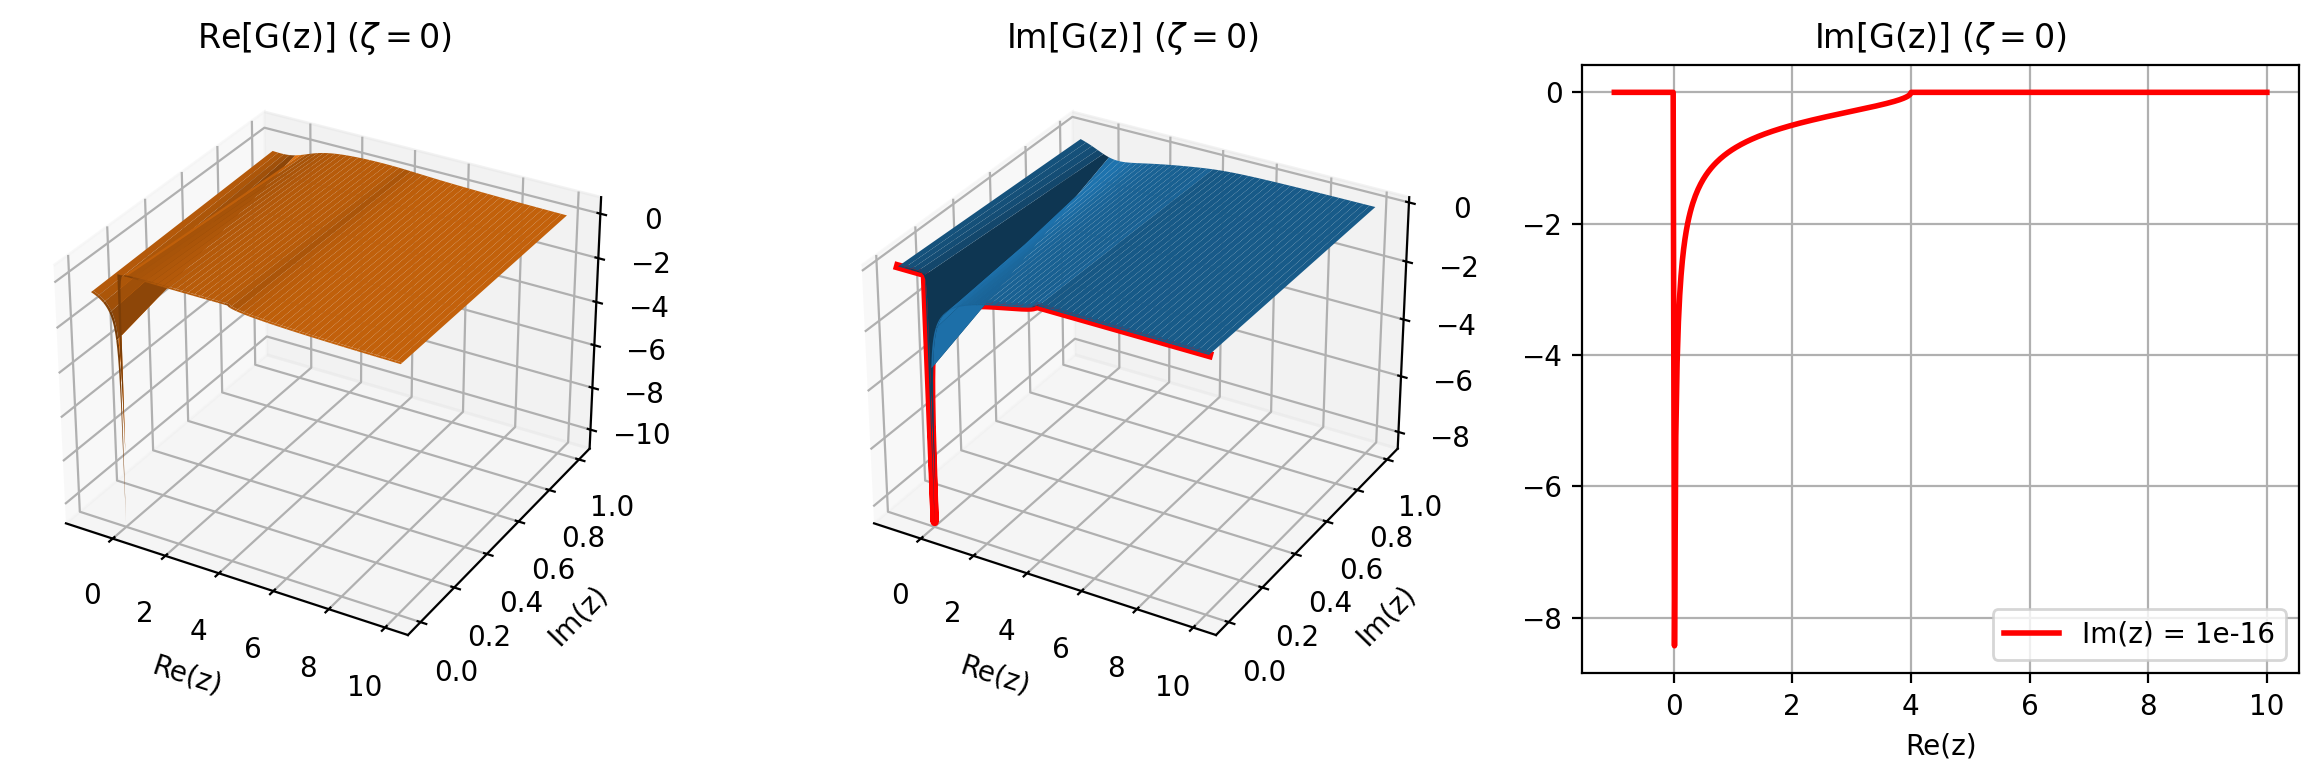

In [6]:
# USE NEWTON'S METHOD TO EVALUATE G AT VARIOUS Z:
def h(G, z, zeta, eta):
    hG = (z ** 2) * (zeta ** 2 - eta * zeta) * (G ** 4)
    hG += (z ** 2) * zeta * (G ** 3)
    hG += z * (eta - zeta) * (G ** 2)
    hG += 1 - z * G
    return hG

def h_prime(G, z, zeta, eta):
    hpG = 4 * (z ** 2) * (zeta ** 2 - eta * zeta) * (G ** 3)
    hpG += 3 * (z ** 2) * zeta * (G ** 2)
    hpG += 2 * z * (eta - zeta) * G - z
    return hpG

def Newton(G0, z, zeta, eta, tol=1e-6):
    G = np.copy(G0)
    err = tol + 1.0

    while err > tol:
        hG = h(G, z, zeta, eta)
        hpG = h_prime(G, z, zeta, eta)

        if np.abs(hpG) < 1e-16:
            # Terminate if h_prime is too small.
            return np.nan
        else:
            # Update G based on Newton Method update.
            G_new = G - hG / hpG
            err = np.abs(G - G_new)
            G = G_new

    return G

# Define grid (Re(z) and Im(z)) at which to evaluate G(z).
zx = np.linspace(-1, 10, 500) # Re(z)
zy = np.logspace(-16, 0, 9) # Im(z)
ZX, ZY = np.meshgrid(zx, zy)
Z = ZX + 1j * ZY # x + iy

# Initialize the routine with G(Z) for zeta = 0.
G0 = G_0(Z)

# Plot the initial conditions for G(z):
print("Initial Conditions for Newton's Method:")
fig = plt.figure(figsize=(12, 4), dpi=200)

# Plot Re(G(z)) as 3-D surface plot.
ax = fig.add_subplot(131, projection="3d")
ax.plot_surface(ZX, ZY, G0.real, color="tab:orange")
ax.set_xlabel("Re(z)")
ax.set_ylabel("Im(z)")
ax.set_title("Re[G(z)] ($\\zeta = 0$)")

# Plot Im(G(z)) as 3-D surface plot.
ax = fig.add_subplot(132, projection="3d")
ax.plot_surface(ZX, ZY, G0.imag, color="tab:blue")
ax.plot(zx, G0[0].imag, zs=0, zdir="y", c="r", lw=3)
ax.set_xlabel("Re(z)")
ax.set_ylabel("Im(z)")
ax.set_title("Im[G(z)] ($\\zeta = 0$)")

# Plot the Im(z) = 0 case in 2-D.
ax = fig.add_subplot(133)
ax.plot(zx, G0[0].imag, c="r", lw=2, label=f"Im(z) = {zy[0]}")
ax.set_title("Im[G(z)] ($\\zeta = 0$)")
ax.set_xlabel("Re(z)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

alpha = -1 (zeta = 1.0)


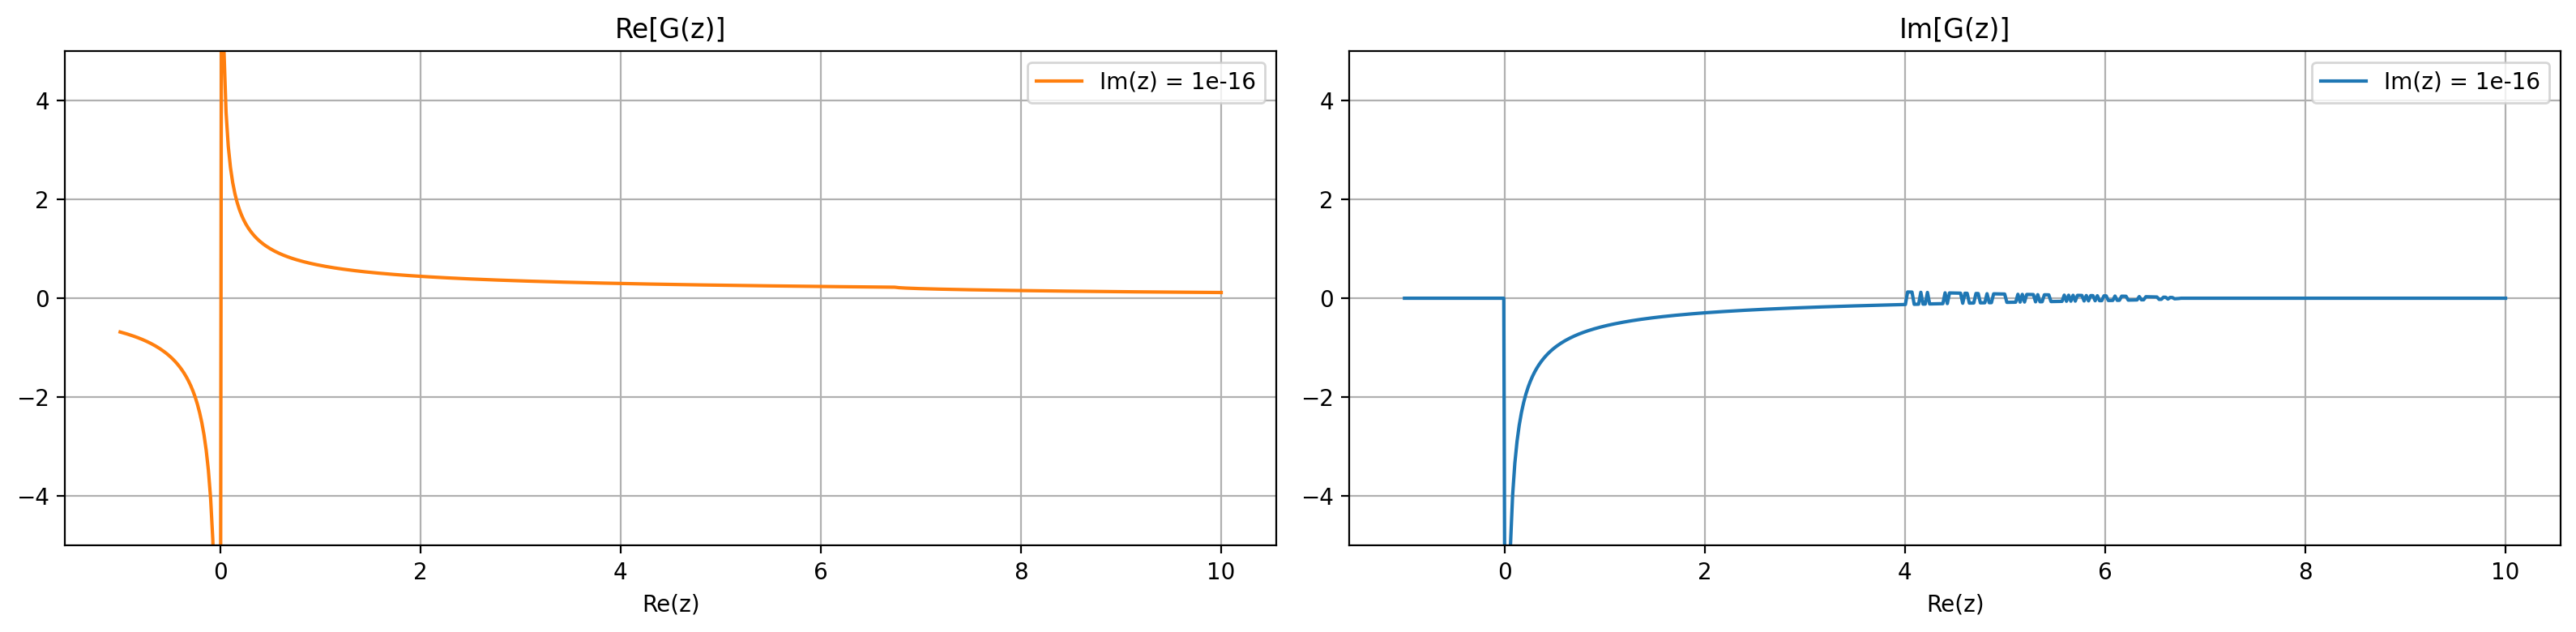

100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


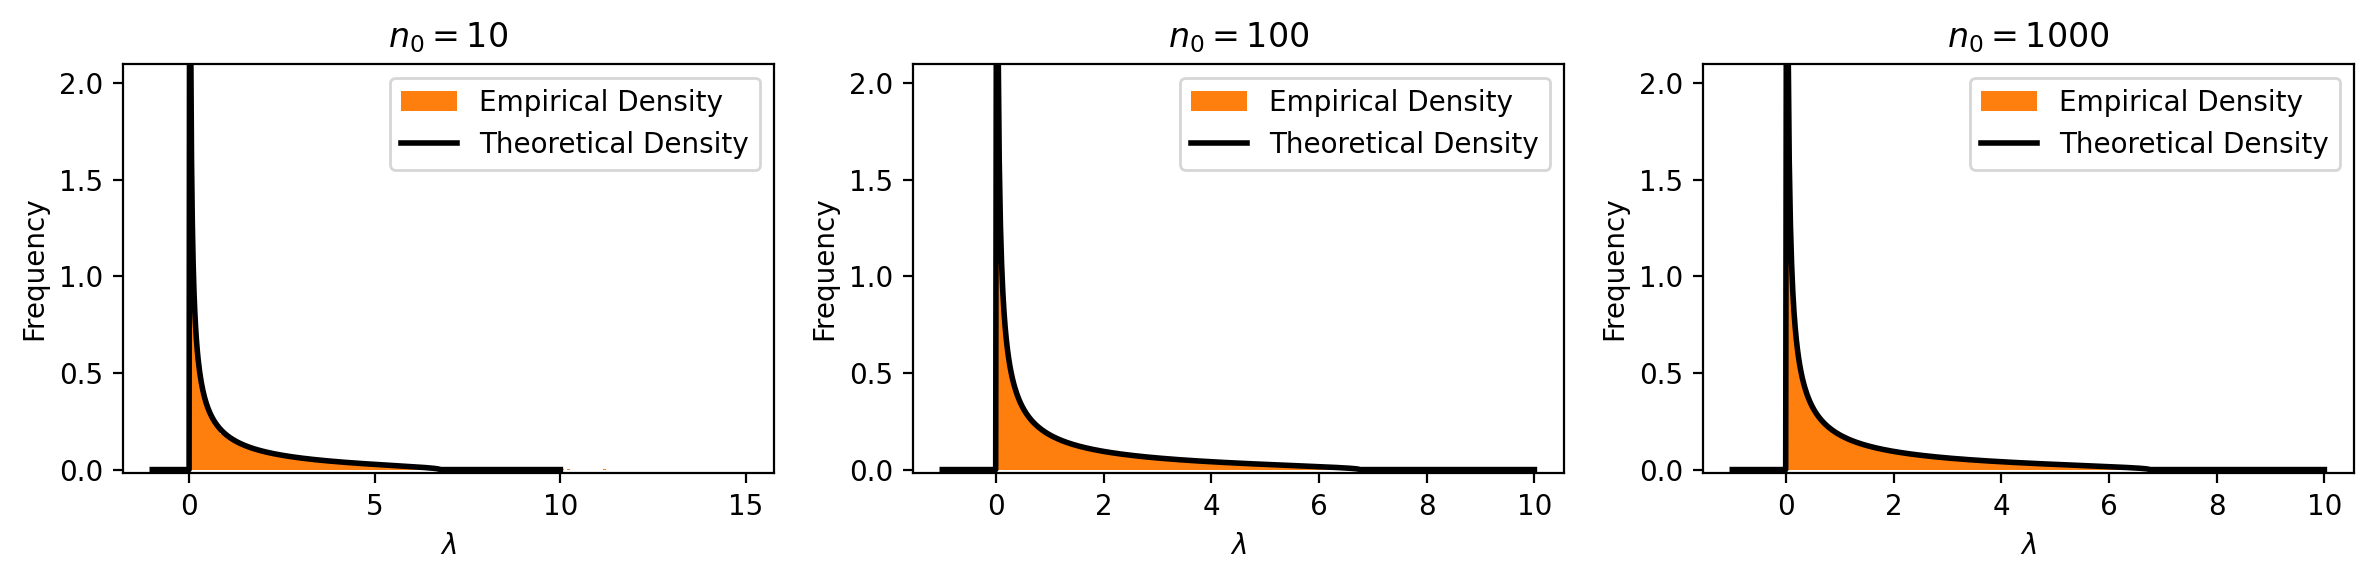

alpha = 0 (zeta = 0.73347110346213)


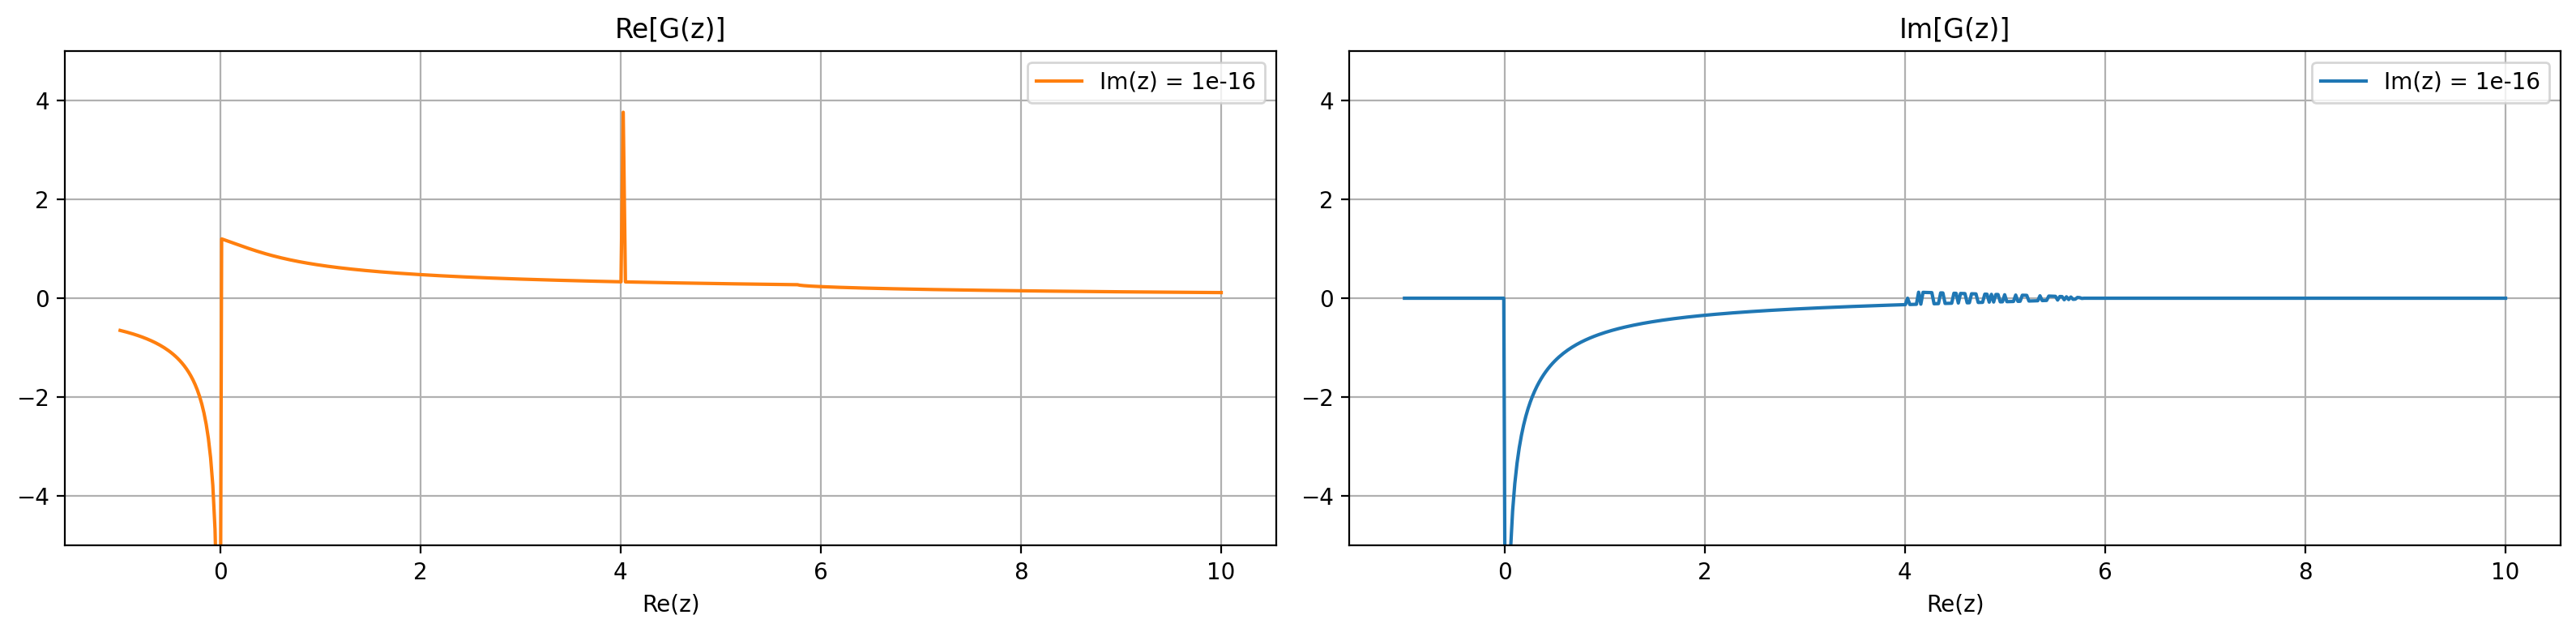

100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


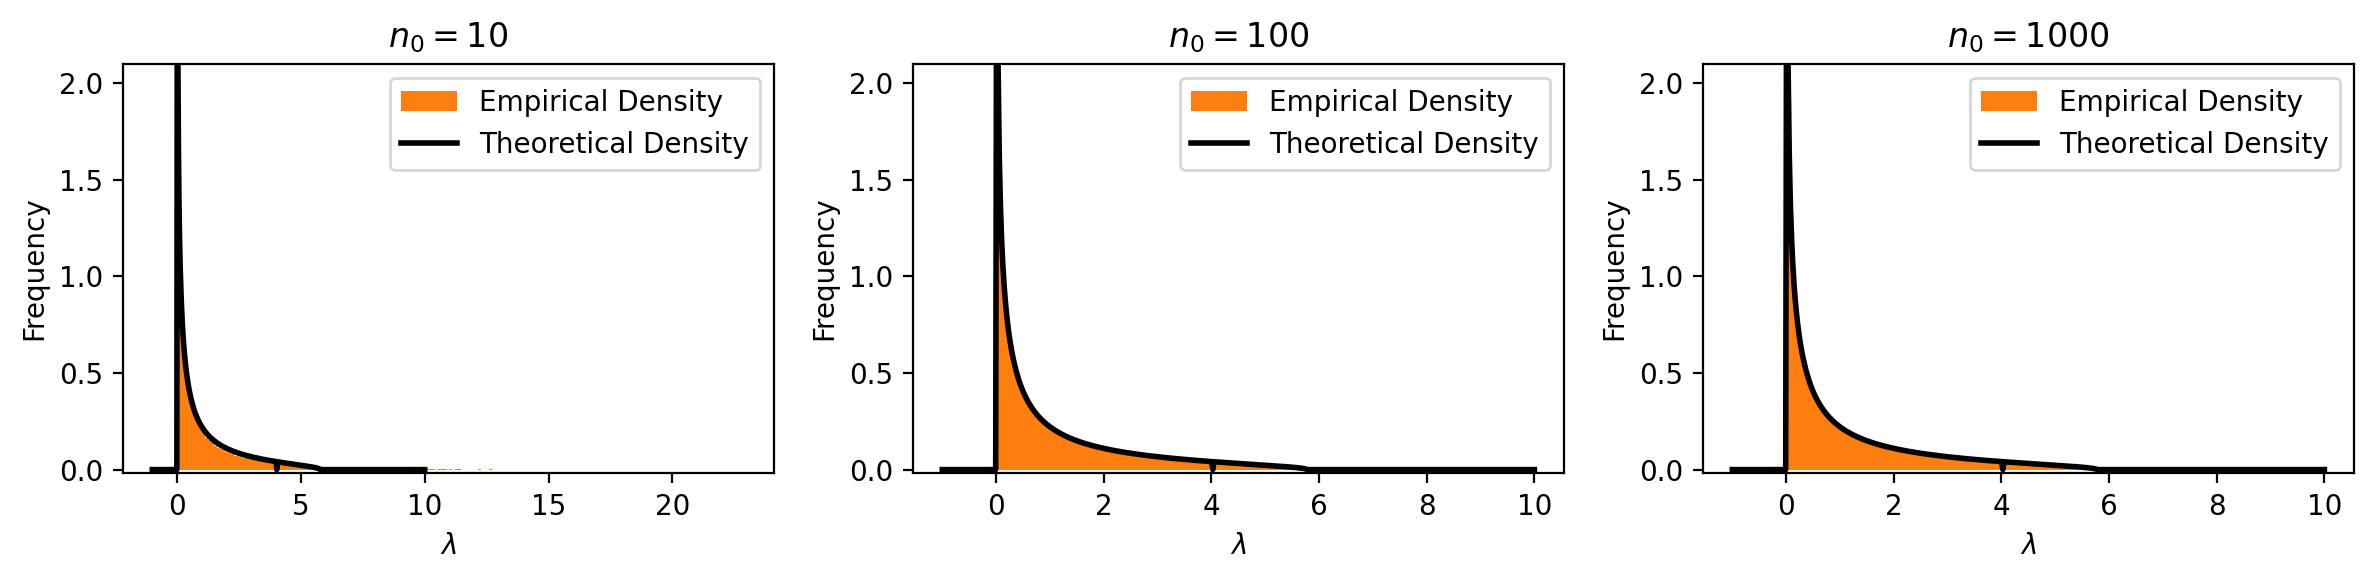

alpha = 0.25 (zeta = 0.4976635885919346)


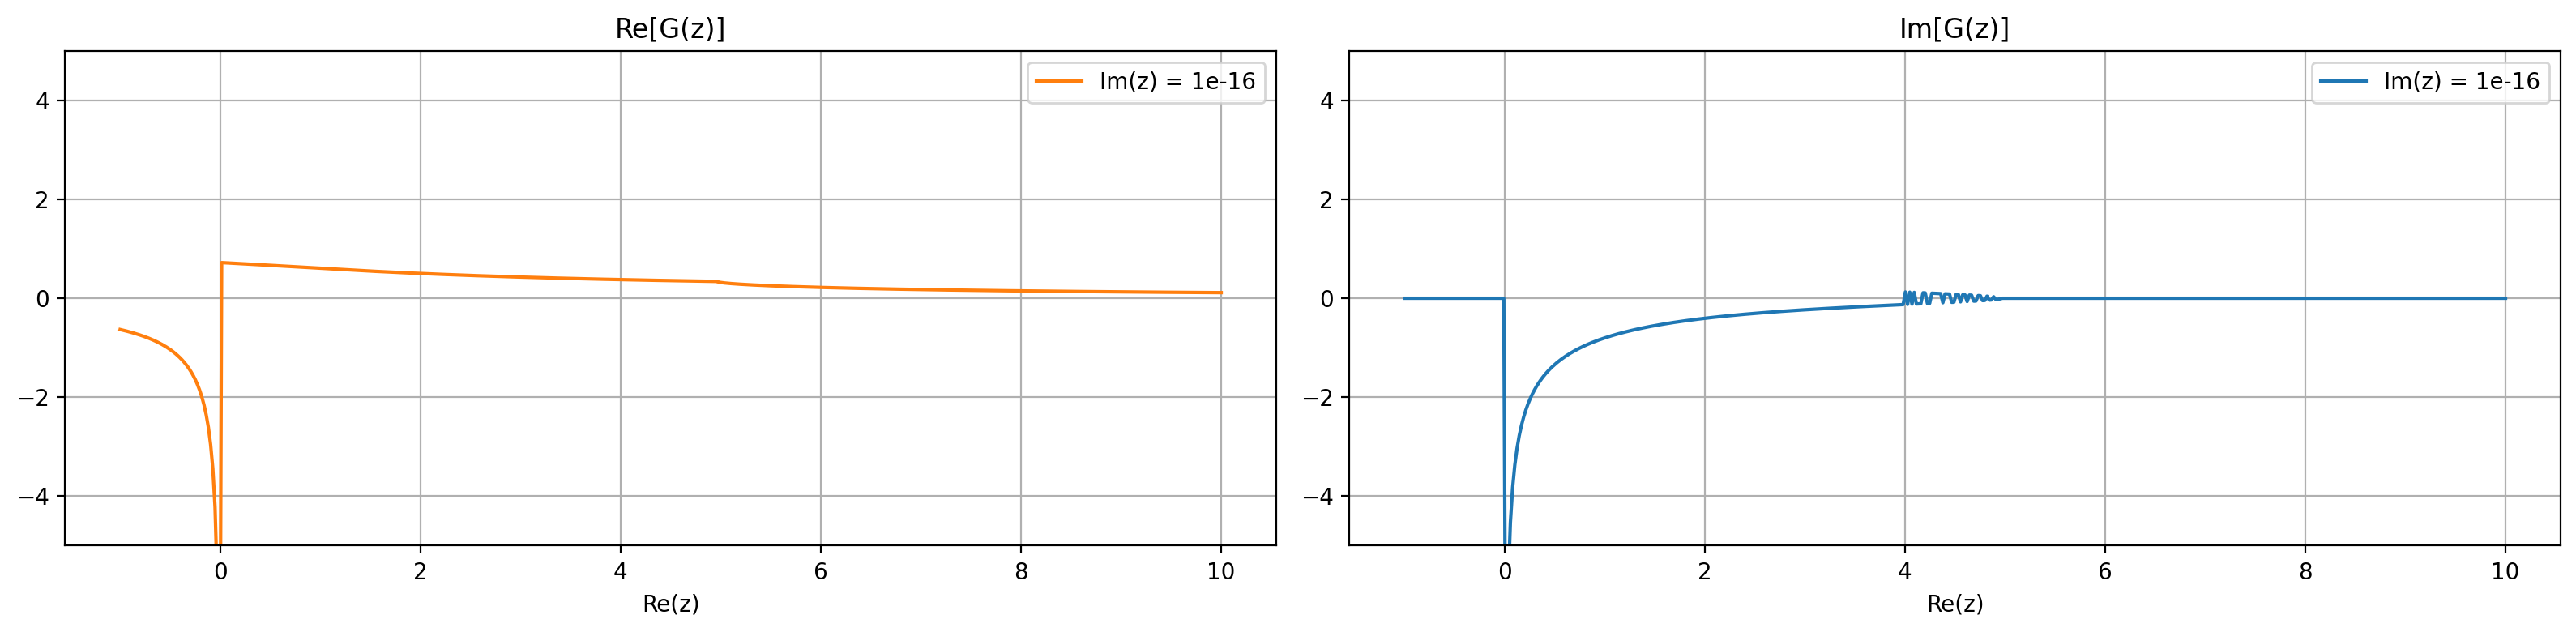

100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


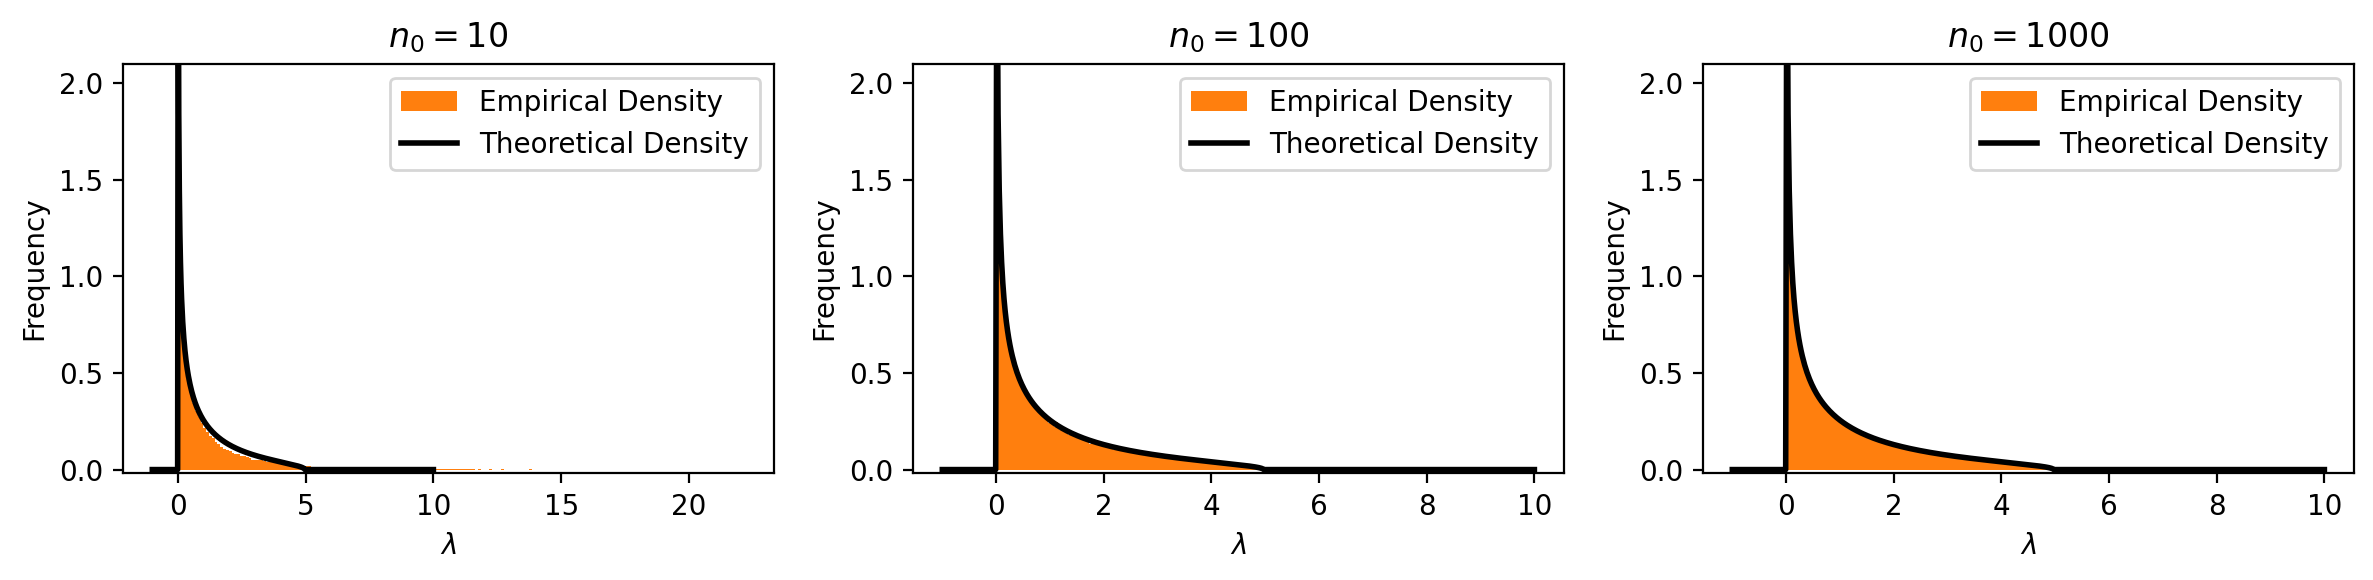

In [7]:
# Choose a new activation function:
for alpha in [-1, 0, 0.25]:
    zeta = compute_zeta(alpha)
    eta = 1
    f = lambda x: relu_modified(x, alpha)
    print(f"alpha = {alpha} (zeta = {zeta})")

    # Evaluate G(z) on the Z grid using Newton's Method.
    GZ = np.empty(Z.shape, dtype="complex")
    for i in range(len(zy)):
        for j in range(len(zx)):
            # Slightly perturb G0 so that we don't learn the zero solution.
            rand_G = 0.01 * (np.random.randn(1)[0] + 1j * np.random.randn(1)[0])
            GZ[i, j] = Newton(G0[i, j] + rand_G, Z[i, j], zeta, eta)

    # # Save reults:
    # np.save(f"newton_results/alpha{alpha}_z", Z[0])
    # np.save(f"newton_results/alpha{alpha}_Gz", GZ[0])
    # Gz = GZ[0]
    Gz = np.load(f"newton_results/alpha{alpha}_Gz.npy")
    Gz_imag = np.where(Gz.imag < 0, Gz.imag, -Gz.imag)
    true_density = -(1 / np.pi) * Gz_imag

    # Plot the results of Newton's Method.
    fig = plt.figure(figsize=(16, 4), dpi=200)
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    # for i in range(0, len(zy), 2):
    #     ax1.plot(zx, GZ[i].real, label=f"Im(z) = {zy[i]}", c="tab:orange", alpha=1-i/len(zy))
    #     ax2.plot(zx, GZ[i].imag, label=f"Im(z) = {zy[i]}", c="tab:blue", alpha=1-i/len(zy))
    ax1.plot(zx, Gz.real, label=f"Im(z) = {zy[0]}", c="tab:orange")
    ax2.plot(zx, Gz.imag, label=f"Im(z) = {zy[0]}", c="tab:blue")
    ax1.set_title("Re[G(z)]")
    ax2.set_title("Im[G(z)]")

    for ax in [ax1, ax2]:
        ax.set_ylim([-5, 5])
        ax.set_xlabel("Re(z)")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()

    # Compute the new empirical distribution:
    all_eigs = []
    n0_vals = np.logspace(1, 3, 3).astype(int)

    for i, n0 in enumerate(n0_vals):
        all_eigs_i = []
        num_trials = int(1e+5 / n0)
        for _ in tqdm(range(num_trials)):
            M = build_gram(n0, f)
            all_eigs_i.append(np.linalg.eigh(M)[0])

        all_eigs.append(all_eigs_i)

    # Plot the empirical densities vs. theoretical.
    plt.figure(figsize=(12, 3), dpi=200)
    for i, (n0, eigs) in enumerate(zip(n0_vals, all_eigs)):
        plt.subplot(1, len(n0_vals), i + 1)

        # (1) Empirical.
        plt.hist(
            np.array(eigs).flatten(),
            density=True,
            bins=200,
            color="tab:orange",
            label="Empirical Density"
        )

        # (2) Theoretical.
        plt.plot(zx, true_density, lw=2, c="k", label="Theoretical Density")

        plt.ylim([-0.02, 2.1])
        plt.title(f"$n_0 = {n0}$")
        plt.xlabel("$\\lambda$")
        plt.ylabel("Frequency")
        plt.legend()

    plt.tight_layout()
    plt.show()

## Part 6: Compute the density for multiple passes

alpha = 1 (zeta = 0)


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


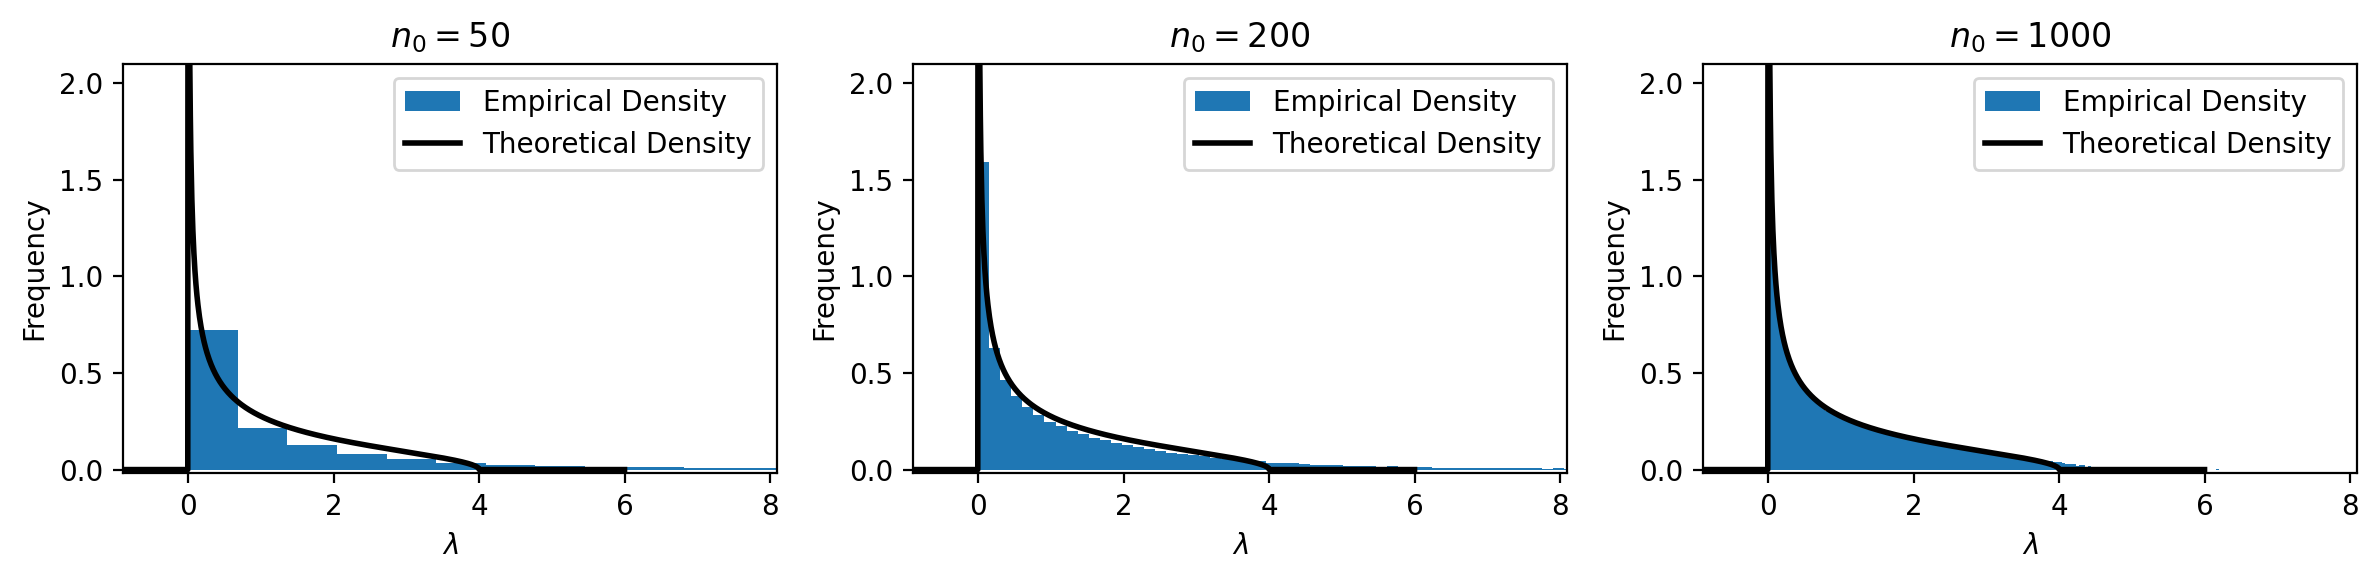

In [8]:
def build_gram_kpass(k, n0_init, f, phi=1, psi=1, sigma_x=1, sigma_w=1):
    n0 = n0_init
    m = int(n0 / phi)
    Y = build_X(n0, m, sigma_x)

    for _ in range(k):
        n1 = int(n0 / psi)
        W = build_W(n0, n1, sigma_w)
        Y = f(W.dot(Y))
        n0 = n1

    M = (1 / m) * Y.dot(Y.T)
    return M

# Declare the number of passes through the NN:
k = 10

# Compute the empirical density after k passes:
all_eigs = []
n0_vals = [50, 200, 1000]

# When alpha = 1, we converge to the theoretical density.
print("alpha = 1 (zeta = 0)")
f = lambda x: relu_modified(x, alpha=1)
z = np.linspace(-1, 6, 1000).astype("complex") + (1j * 1e-16)
true_density = -(1 / np.pi) * G_0(z).imag

for i, n0 in enumerate(n0_vals):
    all_eigs_i = []
    num_trials = int(1e+5 / n0)
    for _ in tqdm(range(num_trials)):
        M = build_gram_kpass(k, n0, f) # perform k passes
        all_eigs_i.append(np.linalg.eigh(M)[0])

    all_eigs.append(all_eigs_i)

# Plot the empirical densities vs. theoretical.
plt.figure(figsize=(12, 3), dpi=200)
for i, (n0, eigs) in enumerate(zip(n0_vals, all_eigs)):
    plt.subplot(1, len(n0_vals), i + 1)

    # (1) Empirical.
    plt.hist(
        np.array(eigs).flatten(),
        density=True,
        bins=int(1e+6 / n0),
        color="tab:blue",
        label="Empirical Density"
    )

    # (2) Theoretical.
    plt.plot(z.real, true_density, lw=2, c="k", label="Theoretical Density")

    plt.xlim([-0.9, 8.1])
    plt.ylim([-0.02, 2.1])
    plt.title(f"$n_0 = {n0}$")
    plt.xlabel("$\\lambda$")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

alpha = -1 (zeta = 1.0)


100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


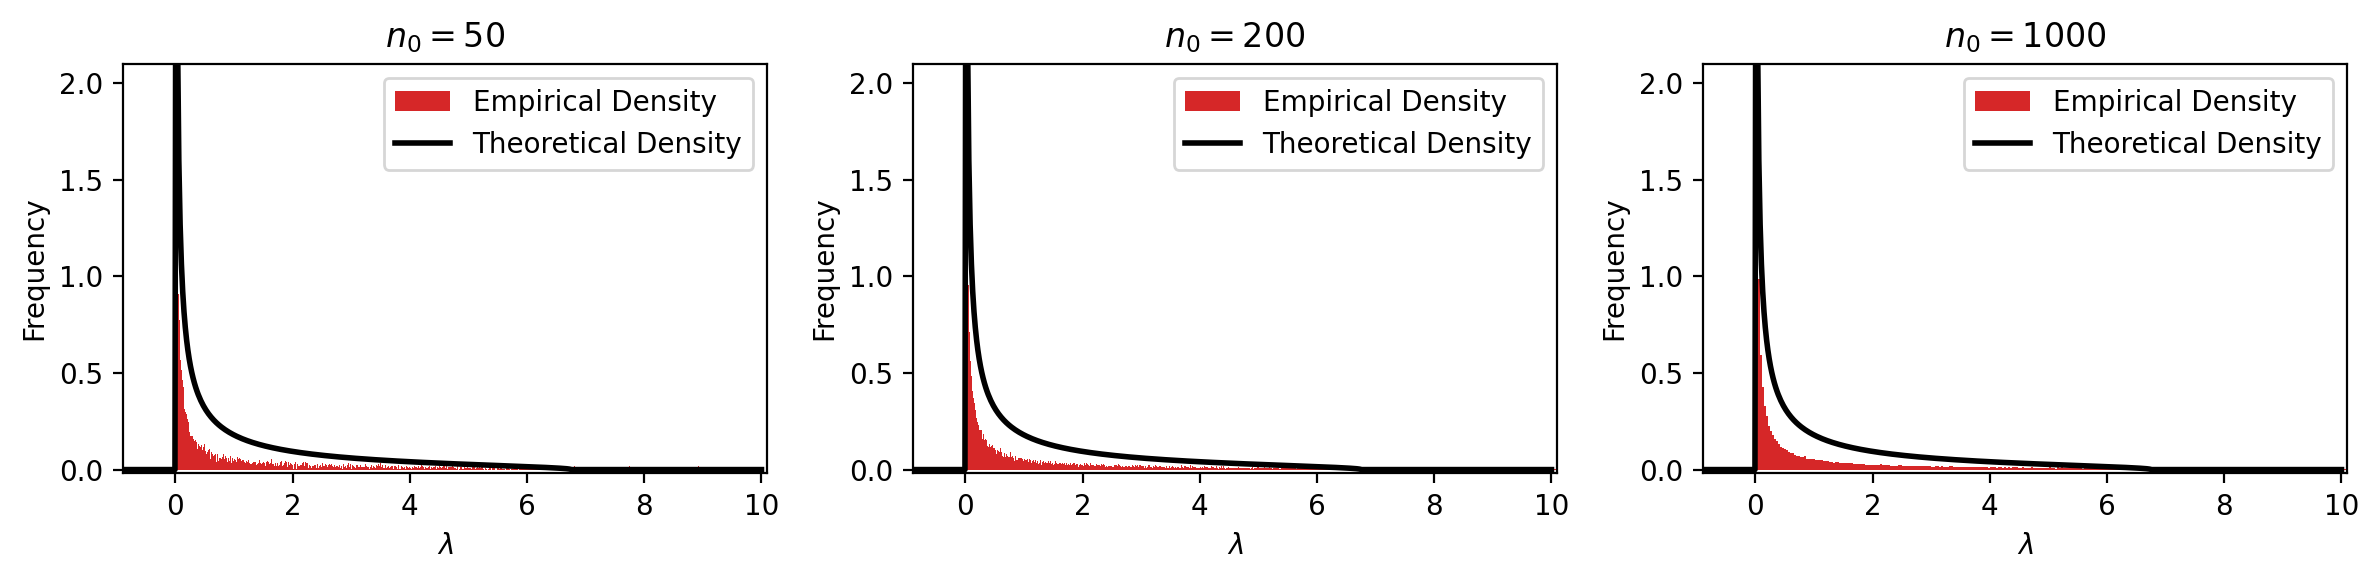

alpha = 0 (zeta = 0.73347110346213)


100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


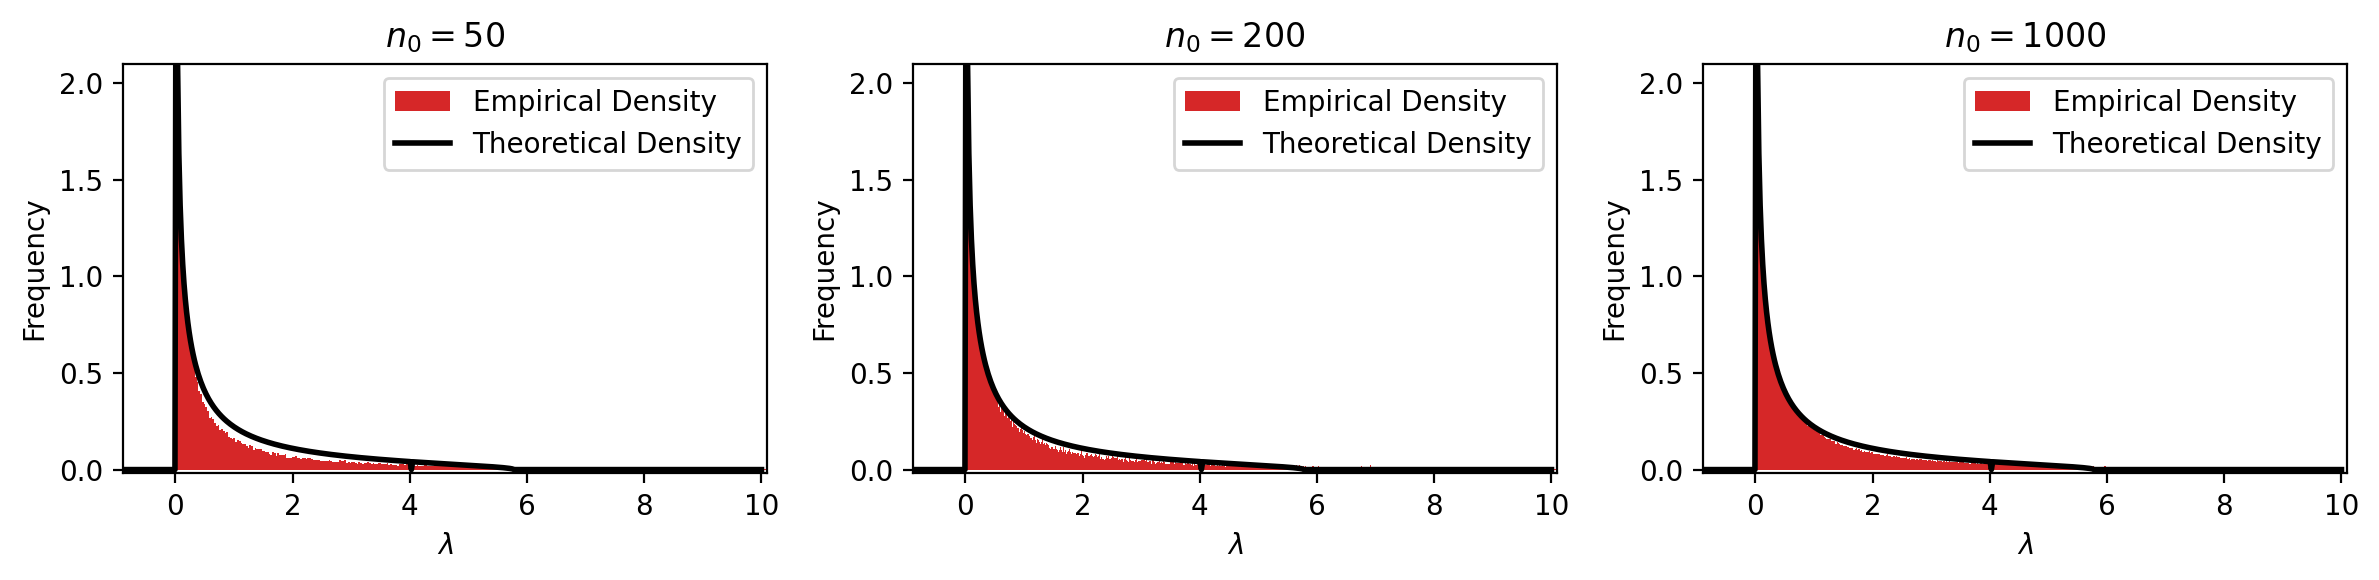

alpha = 0.25 (zeta = 0.4976635885919346)


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


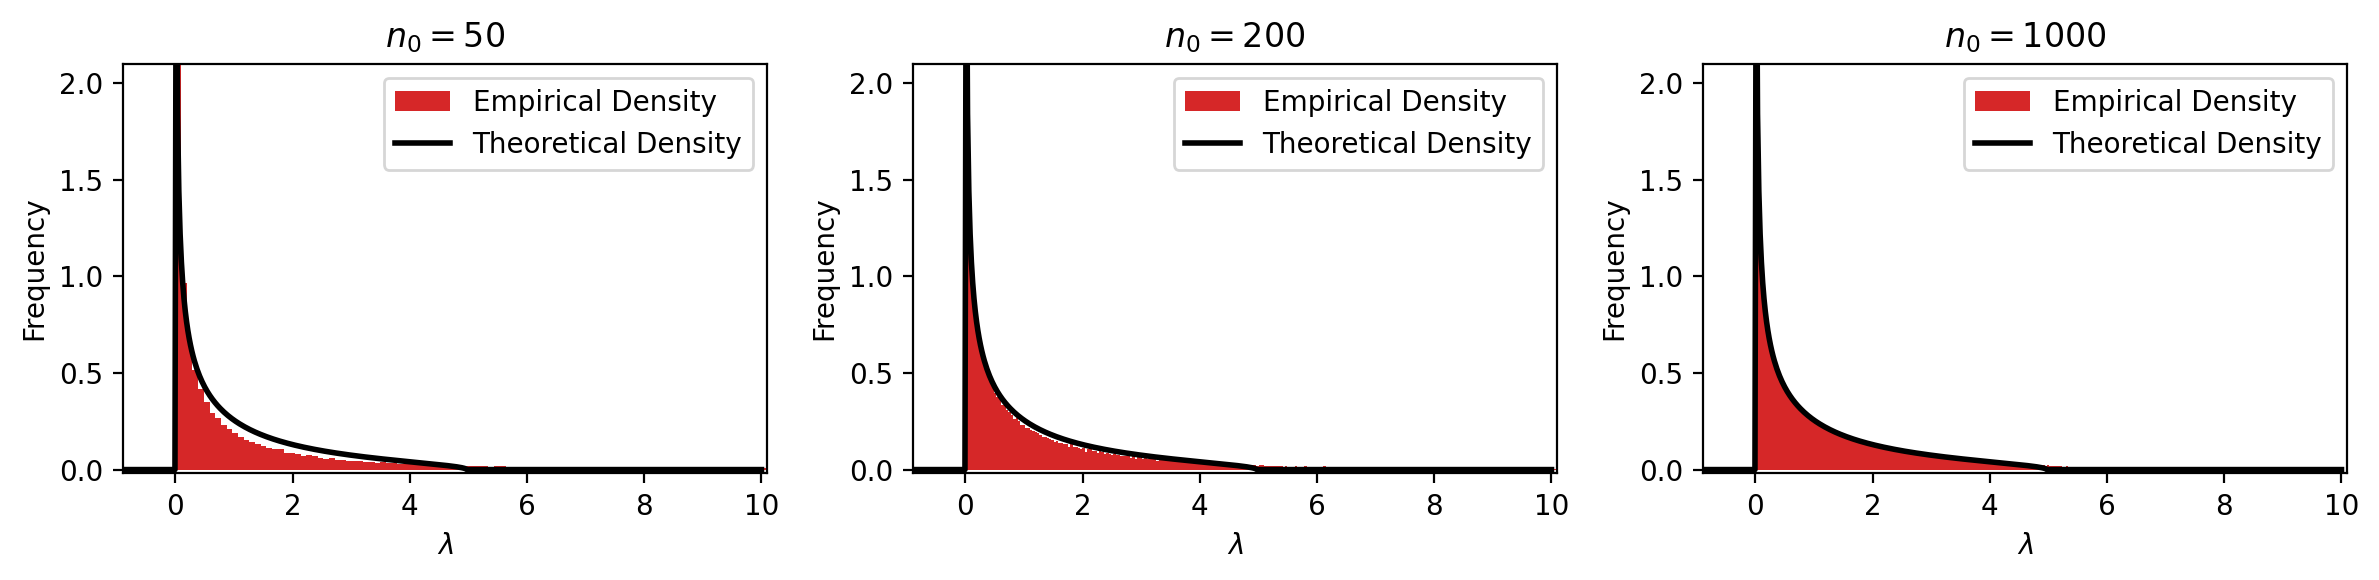

In [9]:
# When alpha is not 1, we don't converge to the theoretical density.
for alpha in [-1, 0, 0.25]:
    zeta = compute_zeta(alpha)
    print(f"alpha = {alpha} (zeta = {zeta})")

    f = lambda x: relu_modified(x, alpha)
    z = np.load(f"newton_results/alpha{alpha}_z.npy")
    Gz = np.load(f"newton_results/alpha{alpha}_Gz.npy")
    Gz_imag = np.where(Gz.imag < 0, Gz.imag, -Gz.imag)
    true_density = -(1 / np.pi) * Gz_imag

    # Compute the empirical density after k passes:
    all_eigs = []
    n0_vals = [50, 200, 1000]
    for i, n0 in enumerate(n0_vals):
        all_eigs_i = []
        num_trials = int(1e+5 / n0)
        for _ in tqdm(range(num_trials)):
            M = build_gram_kpass(k, n0, f) # perform k passes
            all_eigs_i.append(np.linalg.eigh(M)[0])

        all_eigs.append(all_eigs_i)

    # Plot the empirical densities vs. theoretical.
    plt.figure(figsize=(12, 3), dpi=200)
    for i, (n0, eigs) in enumerate(zip(n0_vals, all_eigs)):
        plt.subplot(1, len(n0_vals), i + 1)

        # (1) Empirical.
        plt.hist(
            np.array(eigs).flatten(),
            density=True,
            bins=int(1e+6 / n0),
            color="tab:red",
            label="Empirical Density"
        )

        # (2) Theoretical.
        plt.plot(z.real, true_density, lw=2, c="k", label="Theoretical Density")

        plt.xlim([-0.9, 10.1])
        plt.ylim([-0.02, 2.1])
        plt.title(f"$n_0 = {n0}$")
        plt.xlabel("$\\lambda$")
        plt.ylabel("Frequency")
        plt.legend()

    plt.tight_layout()
    plt.show()